In [1]:
%%capture capt
!pip install pywaffle

In [2]:
%%capture capt
import numpy as np
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pywaffle import Waffle
import math
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap

## Import data

In [101]:
patient = pd.read_csv("../data/profil_patient_cluster.csv")
patient_custom = pd.read_csv('../data/custom_metric/50cluster_50_10_1.csv')

In [102]:
with open('../data/custom_metric/50cluster_medoids_50_10_1.npy', 'rb') as f:
    medoid_custom = np.load(f)

## Preprocessing

In [103]:
def preprocessing(patient):
    patient['CHOC'] = patient['CHOC'].astype(int)
    patient['y_nais'] = 2016 - patient['y_nais']
    #Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
    #Moyenne empirique du nombre de jours hospitalisé
    patient['Nb_jours_moyen'] = patient['Nb_jours_sej'] / patient['Nb_hospit']
    patient = patient.rename(columns={'y_nais':'age'})
    
    nb_cluster = 1
    found_max = False
    while not found_max:
        try:
            patient['cluster'+str(nb_cluster)]
            nb_cluster += 1
        except:
            found_max=True
            
    nb_cluster -= 1
    patient['cluster'] = [1+np.argmax(patient.loc[:, 'cluster1':'cluster'+str(nb_cluster)].iloc[i]) for i in range(len(patient))]
    
    return patient

In [104]:
patient = preprocessing(patient)
patient_custom = preprocessing(patient_custom)

21
51


In [105]:
patient.head(3)

,CODE_PATIENT,date_h0,age,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins,Nb_jours_moyen,cluster
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,...,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...",2.555556,7
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,...,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...",6.375000,17
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,...,0,0,0,0,1,0,0,"11M041,06C194",14.333333,18


# Visualisation des clusters

### Distribution de population par cluster

In [106]:
def pct_cluster(df, title):
    data=df.groupby("cluster").count()["CODE_PATIENT"].sort_values(ascending=False)
    plt.figure(
        FigureClass=Waffle,
        rows=15,
        columns=20,
        title={
            'label': 'Segmentation population par cluster - metrique: ' + title,
            'loc': 'center',
            'fontdict': {
                'fontsize': 10
            }},
        values=data,
        labels=[f"{k} ({int(v / sum(data) * 100)}%)" for k, v in data.items()],  # Legend would not be created without this line
        legend={'title': 'Clusters', 'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'ncol': 2,},
        cmap_name="tab20b"
    )
    plt.plot()

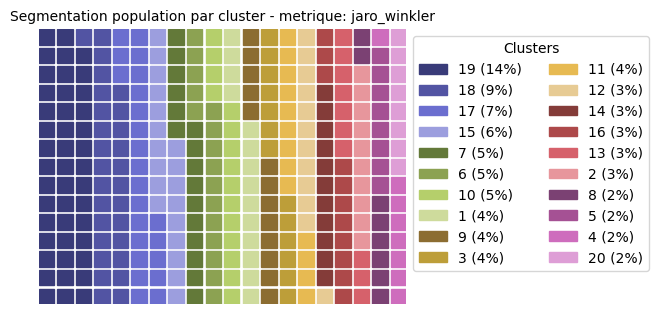

In [107]:
pct_cluster(patient, 'jaro_winkler')

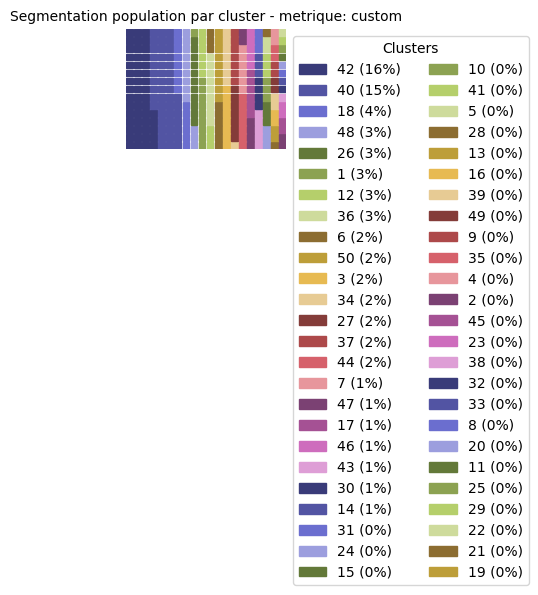

In [108]:
pct_cluster(patient_custom, 'custom')

### Distribution des ages

In [114]:
def hist_age(df, title):
    nb_clusters = len(np.unique(df.cluster))
    fig, axs = plt.subplots(math.ceil(nb_clusters/4), 4, figsize=(20, 4*math.ceil(nb_clusters/4)))
    i = 1
    for ax_i in axs:
        for ax in ax_i:
            df_cluster_i = df.loc[df.cluster == i]
            sns.histplot(data=df_cluster_i.age, kde=True, ax=ax)
            ax.axvline(x=df_cluster_i.age.median(), color='r', label='median')
            ax.axvline(x=df_cluster_i.age.quantile(.25), color='r', linestyle='--', label='q0.25')
            ax.axvline(x=df_cluster_i.age.quantile(.75), color='r', linestyle='-.', label='q0.75')
            ax.set_title('cluster ' + str(i))
            ax.set_xlim([18, 105])
            ax.set_xlabel('')
            i += 1
    
    fig.suptitle("Distribution des ages par cluster - metrique: " + str(title), y=0.92)
    #fig.legend(loc='best')
    plt.show()

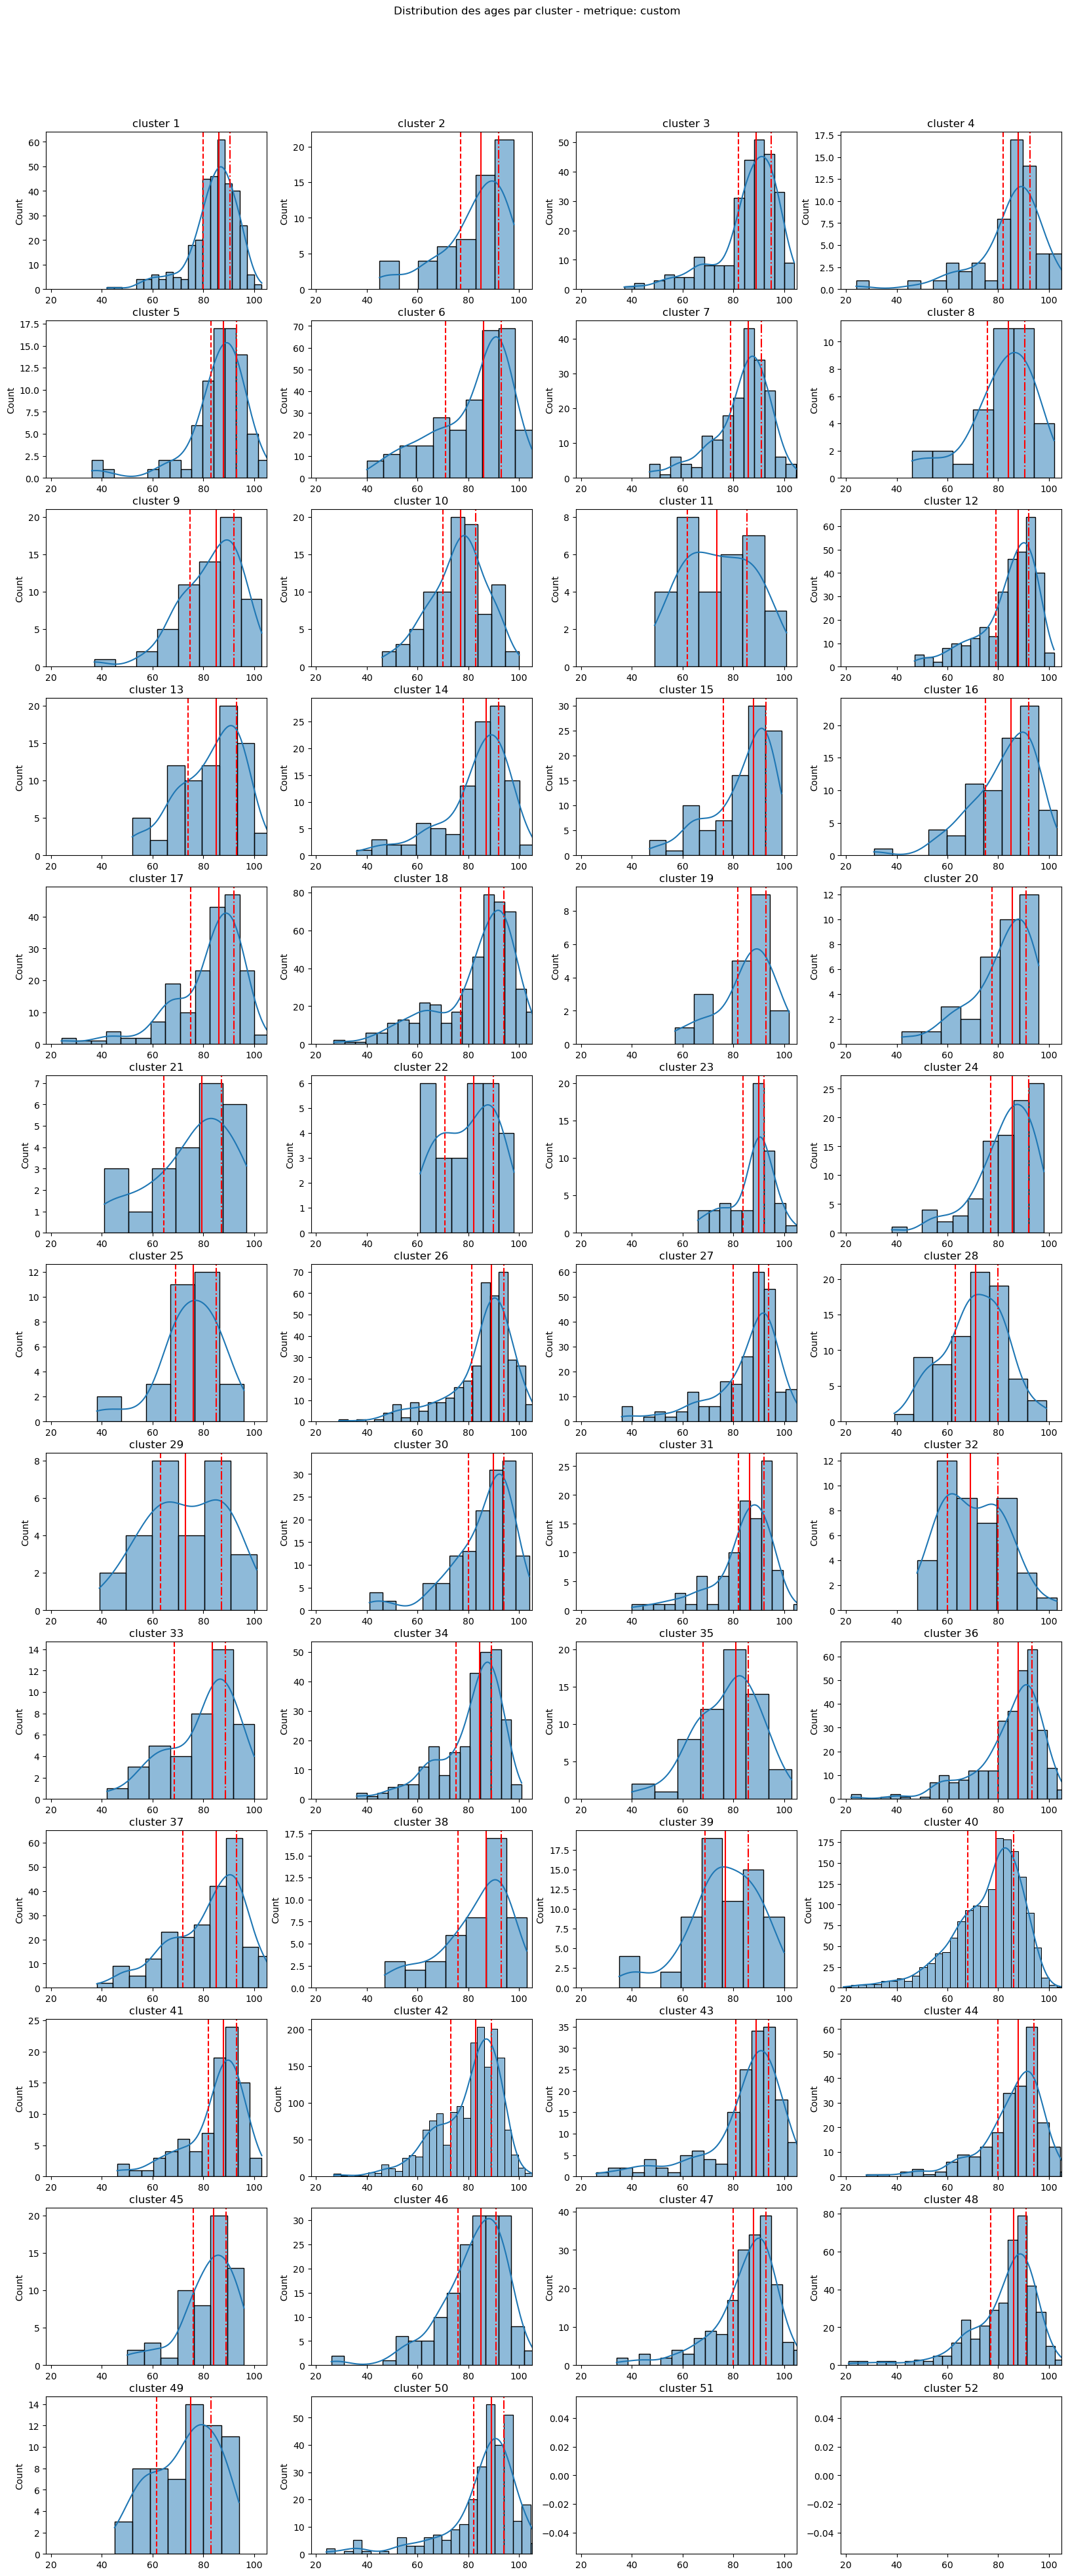

In [115]:
hist_age(patient_custom, 'custom')

### Longueur des parcours de soins

In [116]:
def len_p_soins(df, title):
    nb_clusters = len(np.unique(df.cluster))
    labels = range(1, nb_clusters+1)
    counts = []
    for i in range(1, nb_clusters+1):
        df_cluster_i = df.loc[df.cluster == i]
        len_soins = df_cluster_i.p_soins.apply(lambda ghm: ghm.count(","))
        counts.append(np.median(len_soins))
    plt.bar(labels, counts, align='center', color = 'black')
    plt.gca().set_xticks(labels)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('Longueur médiane des parcours de soins, metrique: ' + title)
    plt.xlabel("Cluster")
    plt.show()

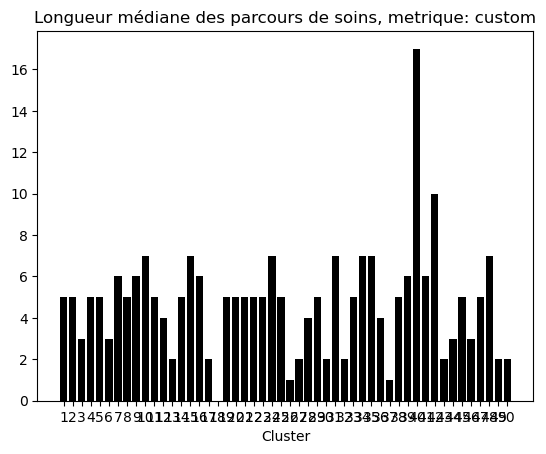

In [117]:
len_p_soins(patient_custom, 'custom')

### Proportions hommes/femmes & morts/vivants

In [61]:
def proportions_hf(df, title):
    nb_clusters = len(np.unique(df.cluster))
    fig, axs = plt.subplots(math.ceil(nb_clusters//4), 4, figsize=(20, 4*math.ceil(nb_clusters//4)))
    i = 1
    for ax_i in axs:
        for ax in ax_i:
            df_cluster_i = df.loc[df.cluster == i]
            sns.countplot(x="BEN_SEX_COD", data=df_cluster_i, ax=ax)
            ax.set_title("(1: homme | 2: femme)")
            ax.bar_label(ax.containers[0])
            ax.set_xlabel("")
            ax.set_ylabel('')
            i += 1            
            
    fig.suptitle("Distribution des sexes par cluster - metrique: " + str(title))
    plt.show()

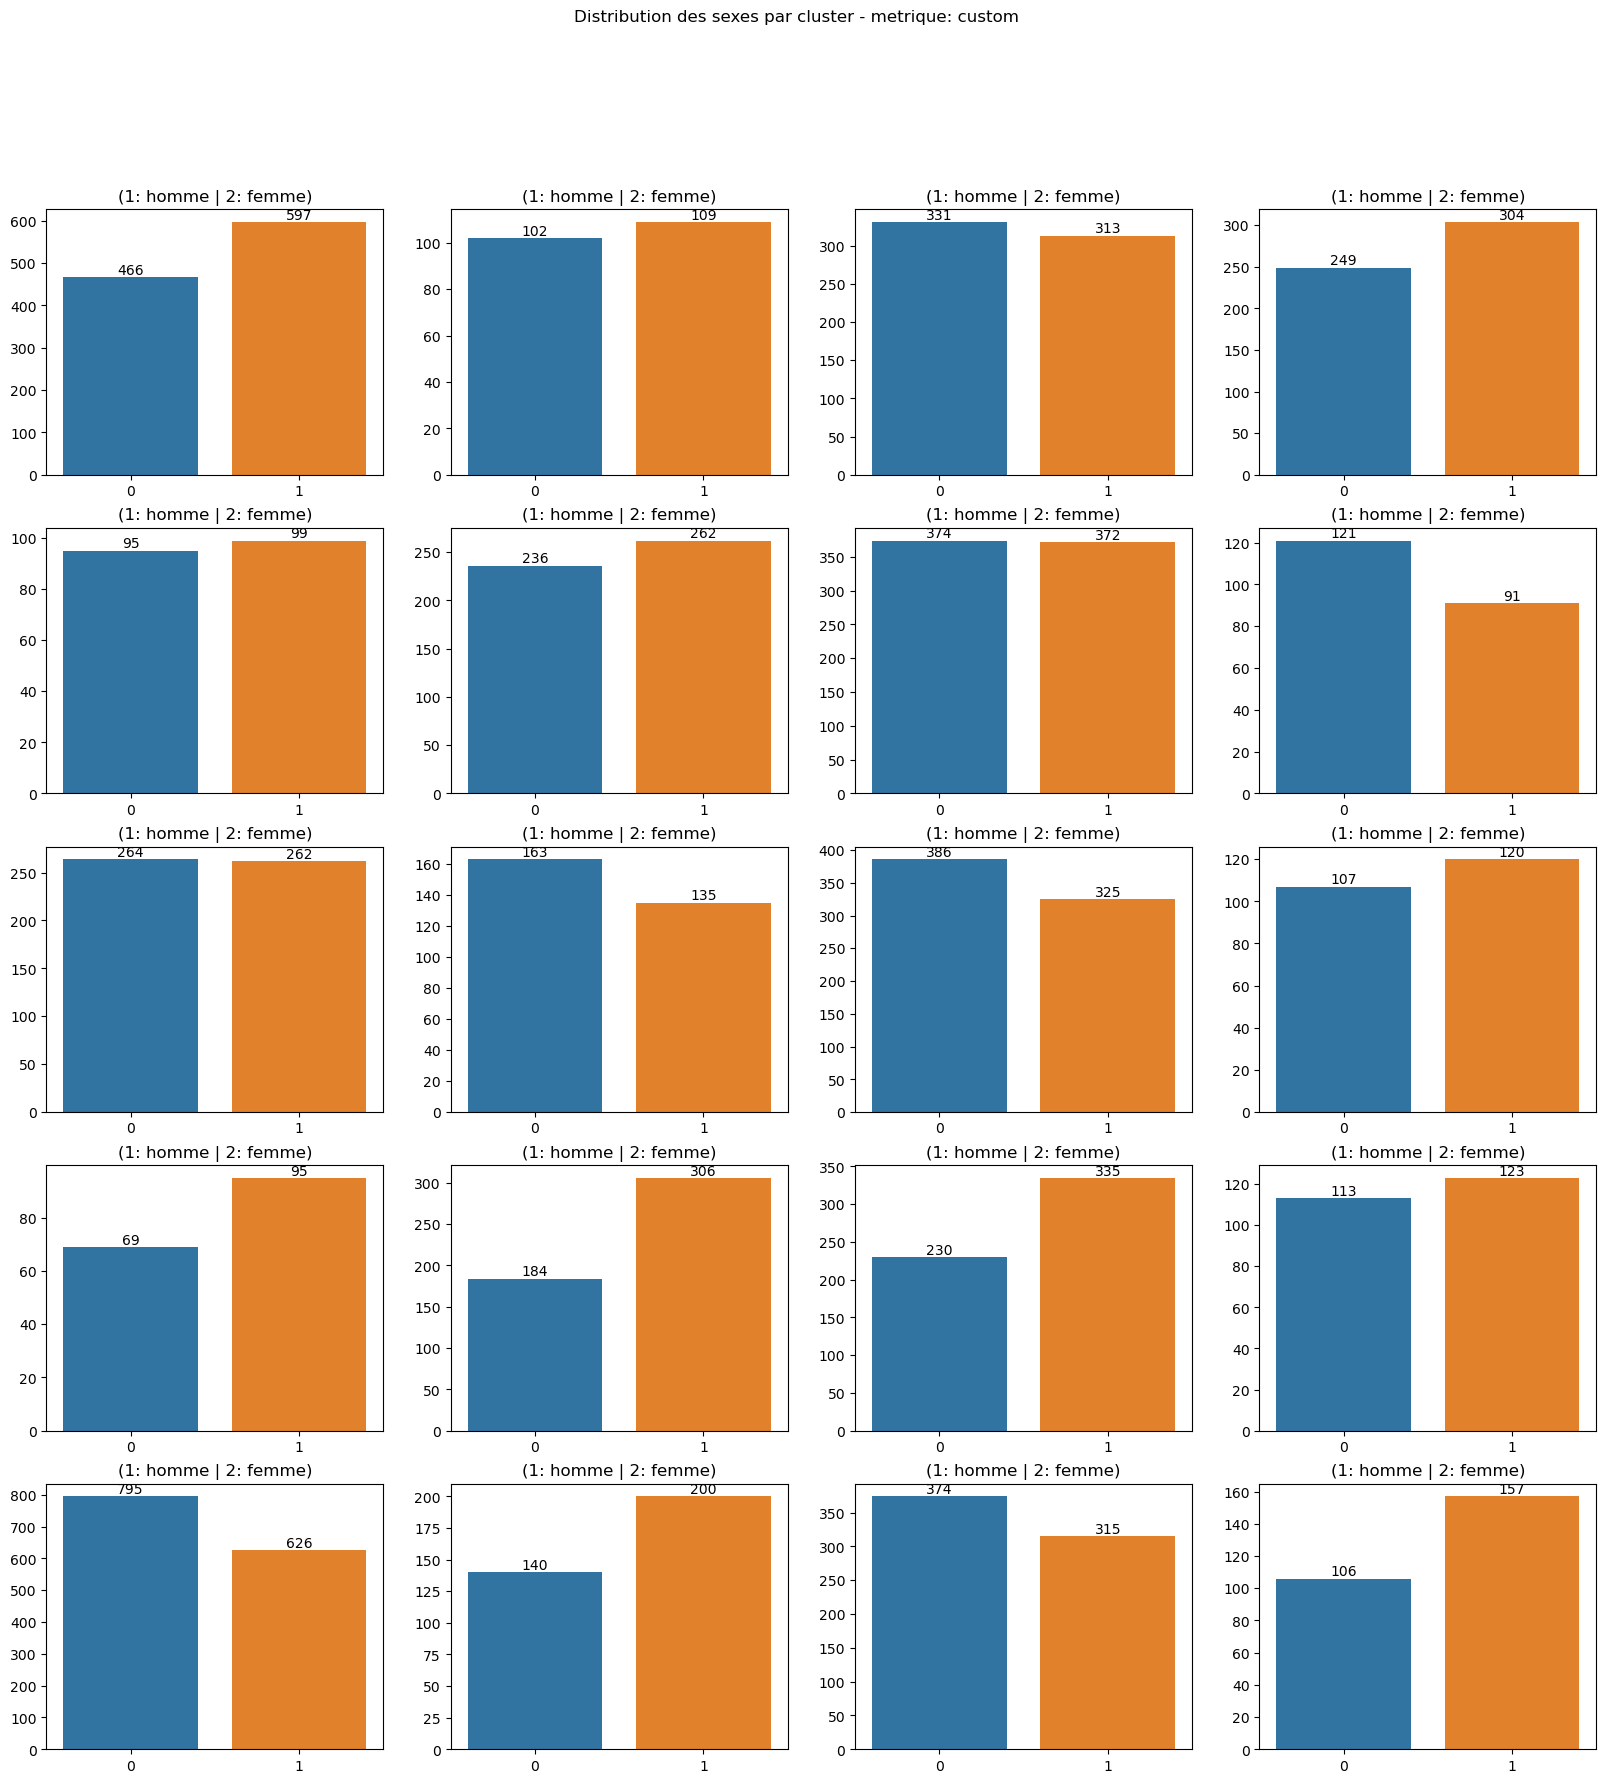

In [62]:
proportions_hf(patient_custom, 'custom')

In [63]:
def proportions_morts(df, title):
    nb_clusters = len(np.unique(df.cluster))
    fig, axs = plt.subplots(math.ceil(nb_clusters//4), 4, figsize=(20, 4*math.ceil(nb_clusters//4)))
    i = 1
    for ax_i in axs:
        for ax in ax_i:
            df_cluster_i = df.loc[df.cluster == i]
            sns.countplot(x="BEN_SEX_COD", hue="Mort", data=df_cluster_i, ax=ax)
            ax.set_xlabel("Sexe")
            ax.bar_label(ax.containers[0])
            ax.bar_label(ax.containers[1])
            i += 1            
            
    fig.suptitle("Distribution des morts par sexe par cluster - metrique: " + str(title))
    plt.show()

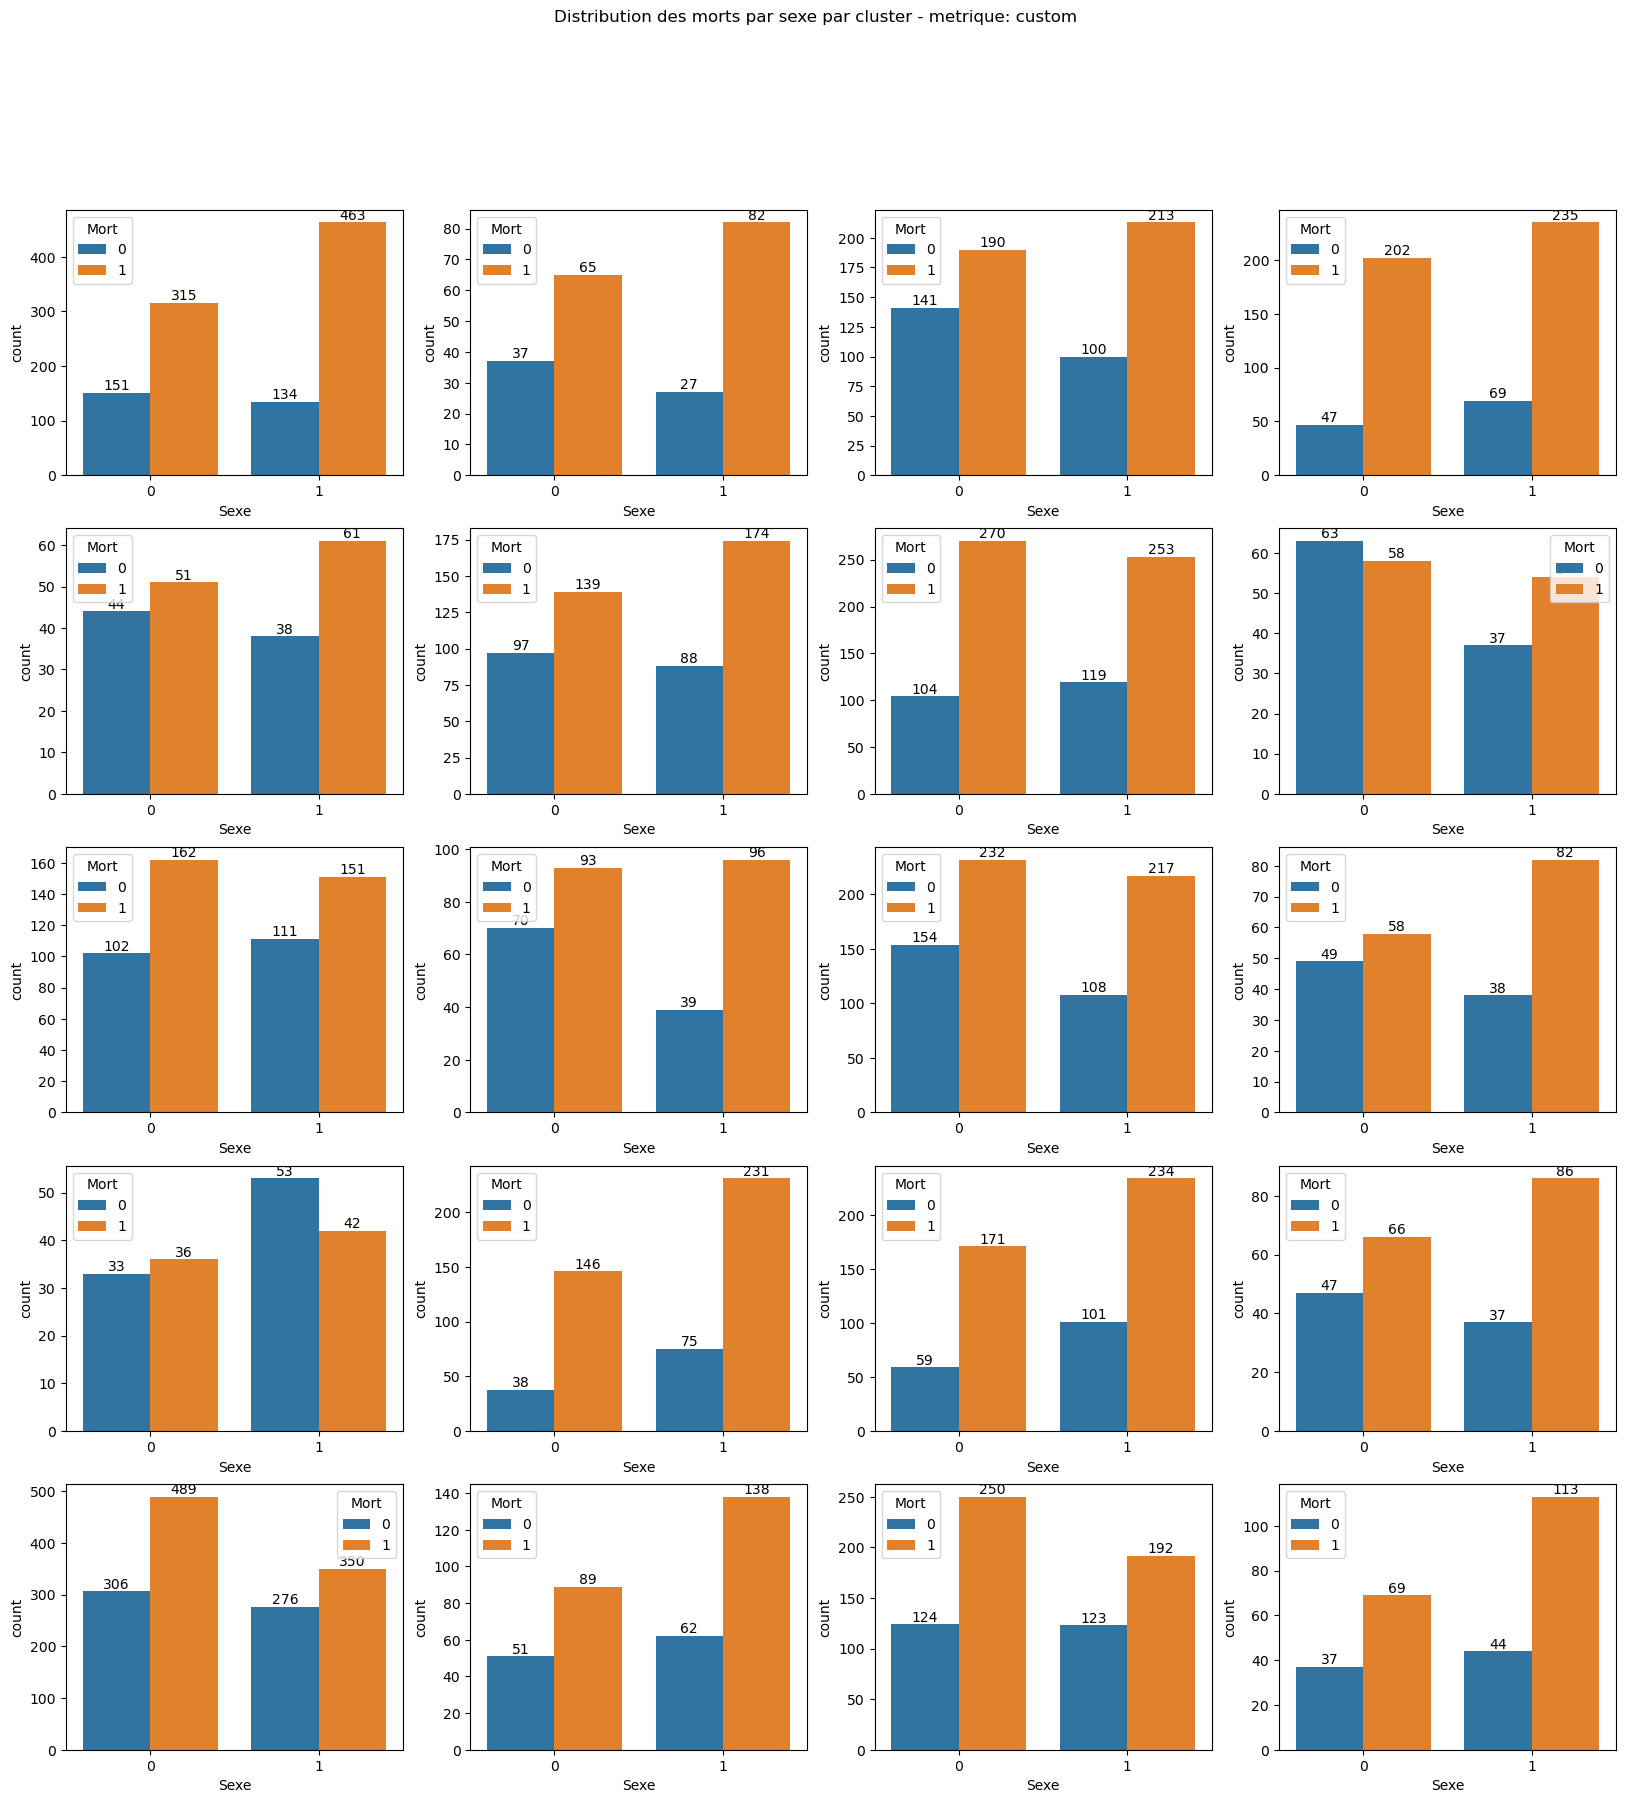

In [64]:
proportions_morts(patient_custom, 'custom')

### Medoids des clusters

In [118]:
def get_matrix_ghm_cluster(df, medoids, cluster, nb=50):
    medoid = medoids[cluster-1]
    ghm_medoid = df.p_soins.iloc[medoid].split(",")
    
    df_cluster = df.loc[(df.cluster == cluster) & (df.index != medoid)]
    indices_to_choose = np.random.choice(df_cluster.p_soins, min(nb, len(df_cluster)), replace=False)
    return indices_to_choose, ghm_medoid

def check_ghm_presence(df, medoids, cluster, nb=50):
    ghm_cluster, ghm_medoid = get_matrix_ghm_cluster(df, medoids, cluster, nb)
    col_matrix = max(np.max(list(map(lambda ghm: len(ghm.split(',')), ghm_cluster))), len(ghm_medoid))
    
    matrix = np.zeros((len(ghm_cluster), col_matrix))+2
    for i in range(len(ghm_cluster)):
        ghm = ghm_cluster[i].split(",")
        for j in range(len(ghm)):
            if ghm[j] in ghm_medoid:
                matrix[i][j] = 1
            else:
                matrix[i][j] = 0
                
    return matrix

In [124]:
def ghm_communs_medoids(df, medoids, title, nb=50):

    my_colors = ['darkgrey', 'darkgreen', 'black']
    my_cmap = ListedColormap(my_colors)
    bounds = [0, 1, 2, 3]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))
    
    nb_clusters = len(np.unique(df.cluster))
    fig, axs = plt.subplots(math.ceil(nb_clusters/4), 4, figsize=(20, 4*math.ceil(nb_clusters/4)))
    i = 1
    for ax_i in axs:
        for ax in ax_i:
            try:
                matrix = check_ghm_presence(df, medoids, i, nb)
                heatmap = ax.imshow(matrix, cmap=my_cmap, norm=my_norm, aspect='auto')
                ax.set_yticks([])
                if len(matrix[0]) <= 15:
                    ax.set_xticks(range(len(matrix[0])))
            except:
                pass
            ax.set_title('Cluster ' + str(i))
            i += 1 

    # add global legend
    fig.subplots_adjust(bottom=0.002)
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.01])
    cbar = fig.colorbar(heatmap, orientation = 'horizontal', cax=cbar_ax, ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3], aspect=1)
    cbar.ax.set_xticklabels(['', 'GHM non commun', '', 'GHM commun', '', 'Hors parcours soin', ''], fontdict = {'fontsize': 4*math.ceil(nb_clusters//4)//2})
    
    fig.suptitle("GHM communs avec medoid du cluster - metrique: " + str(title), y=0.92, fontsize=15)
    plt.show()

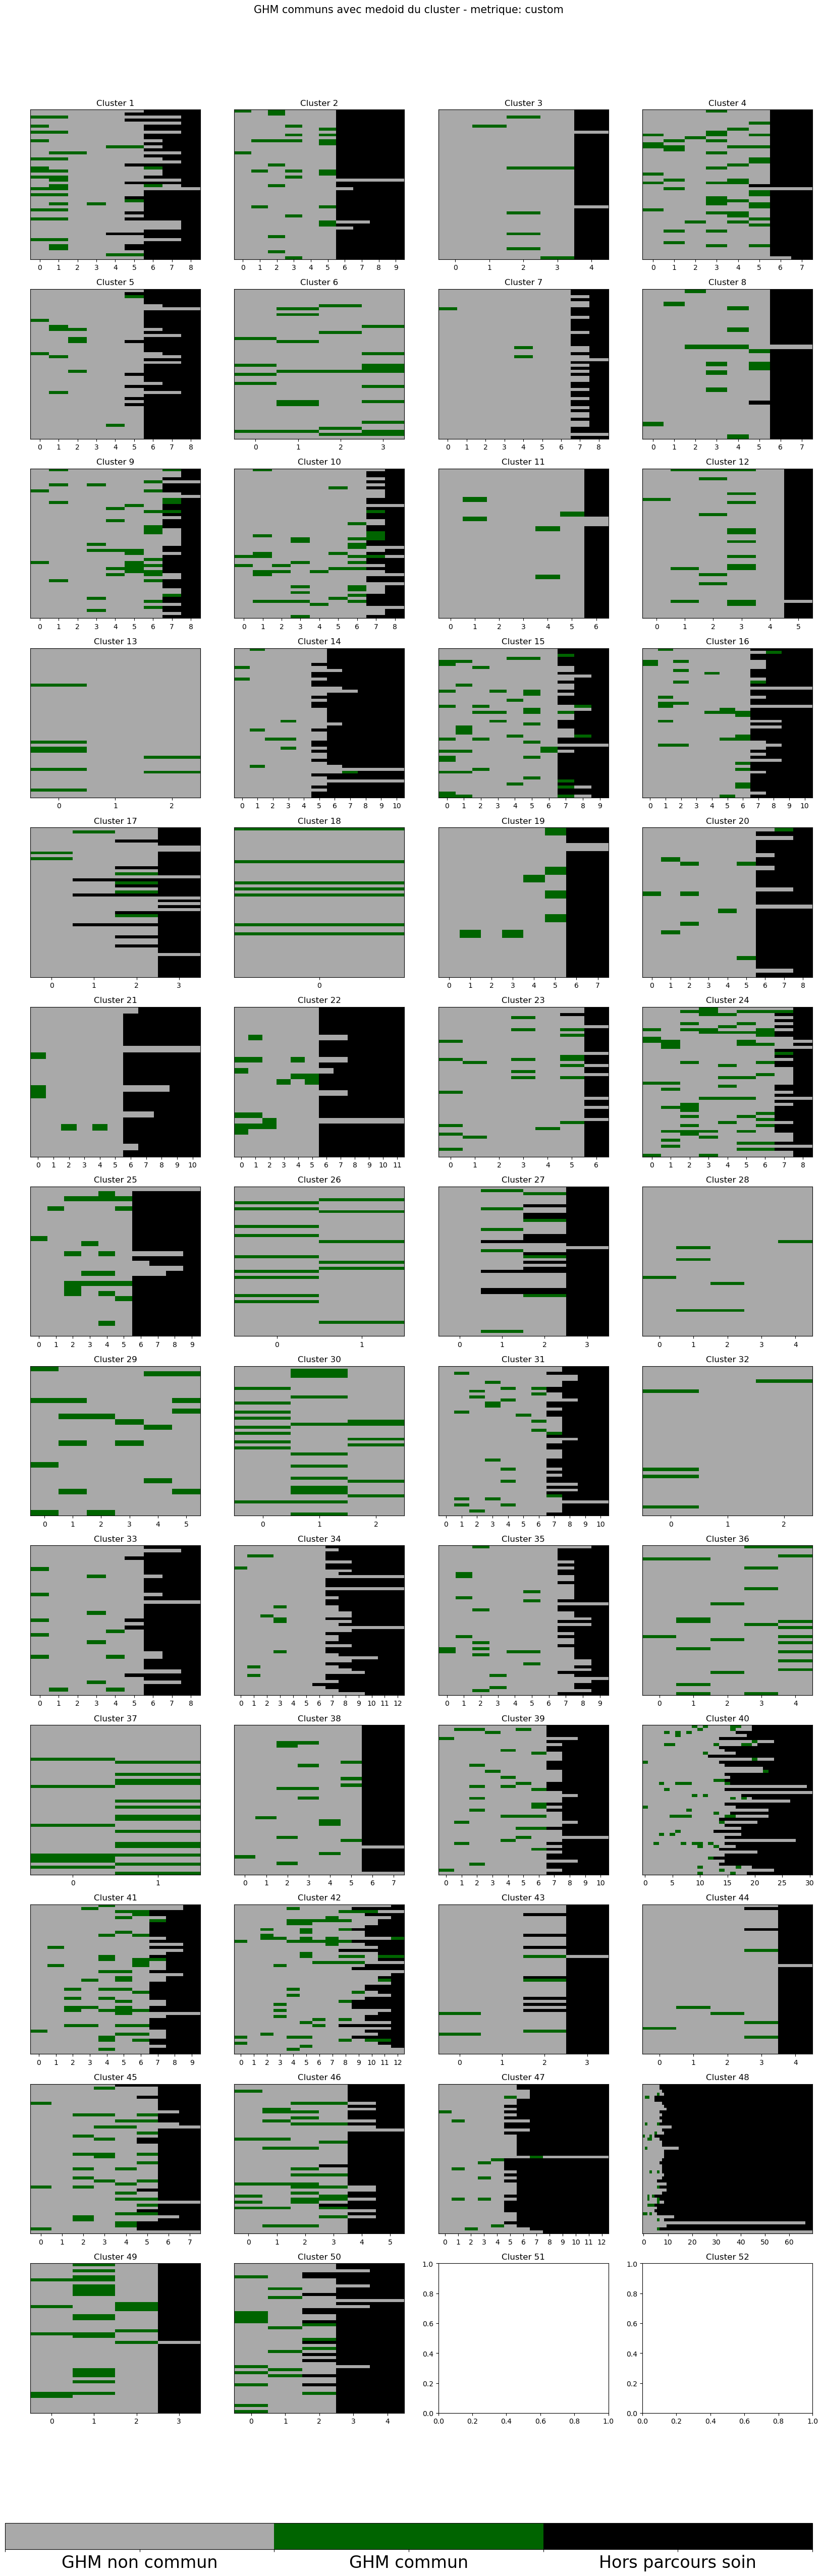

In [125]:
ghm_communs_medoids(patient_custom, medoid_custom, 'custom', nb=50)

In [128]:
patient_custom.loc[patient_custom.cluster == 10][['CODE_PATIENT', 'p_soins']]

,CODE_PATIENT,p_soins
178,P464,"24C03Z,24C03Z,08C423,05M091,08M102,08M102,05M0..."
326,P836,"05C102,11M121,05K101,05M092,12C043,23M20T,05M091"
451,P1135,"05K102,05M091,05K101,05C192,05K061,05M091,05C192"
1071,P2657,"05K101,08M152,05C191,05M082,05M08T,05K101,05K1..."
1130,P2800,"06K02Z,03C091,06C044,23M20T,06C241,09C102,06K0..."
...,...,...
9444,P22826,"12K06J,08C322,05K051,05M091,01C15J,01C15J,05M09T"
9497,P22964,"05K101,05M08T,03C242,05M09T,23M20Z,05M09T,05C024"
9527,P23030,"05K052,05M093,04M112,02C05J,05M092,05M092,05C1..."
9638,P23305,"05K101,05C191,16M11T,05M122,02C05J,05K101,05C0..."


In [126]:
def hist_len_p_soins_cluster(df, cluster):
    df_cluster = df.loc[df.cluster == cluster]
    lengths = df_cluster.p_soins.apply(lambda ghm: len(ghm.split(",")))
    plt.hist(lengths, bins = 15)
    plt.show()

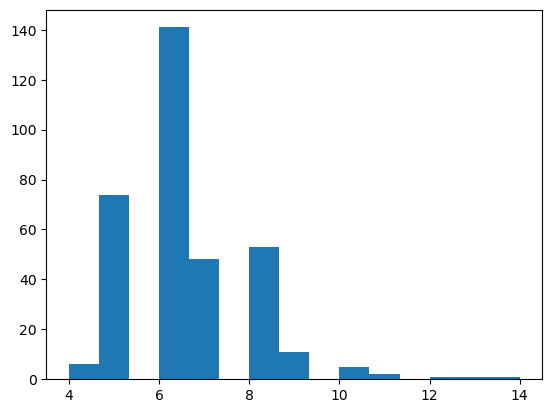

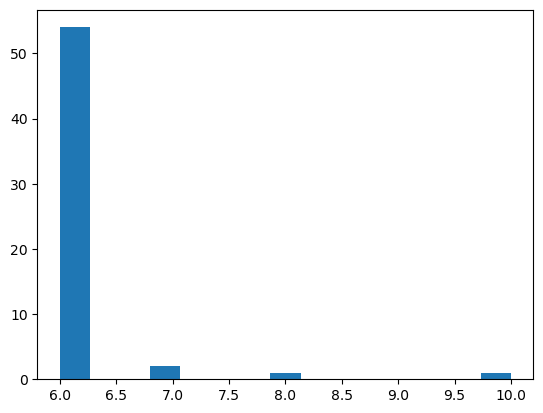

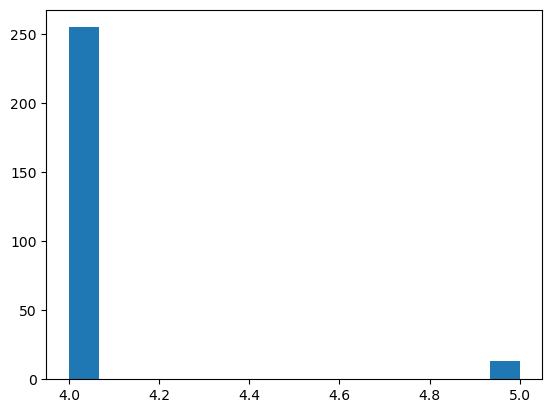

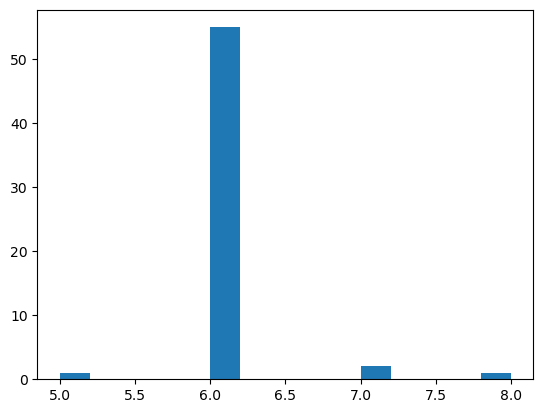

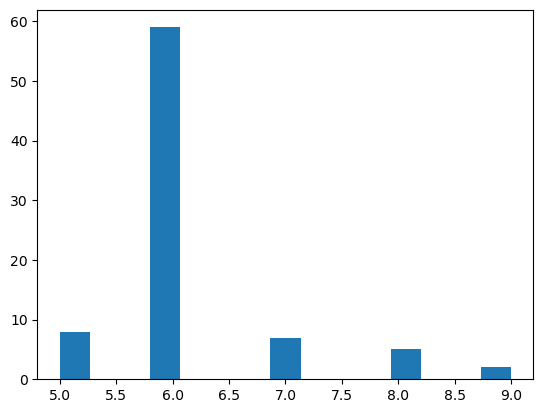

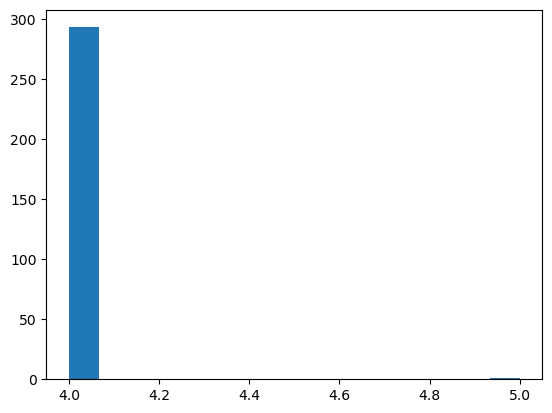

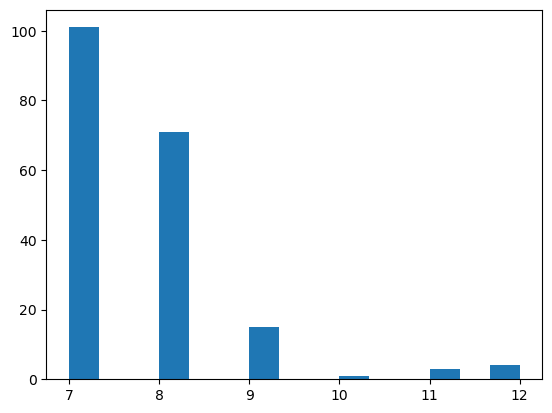

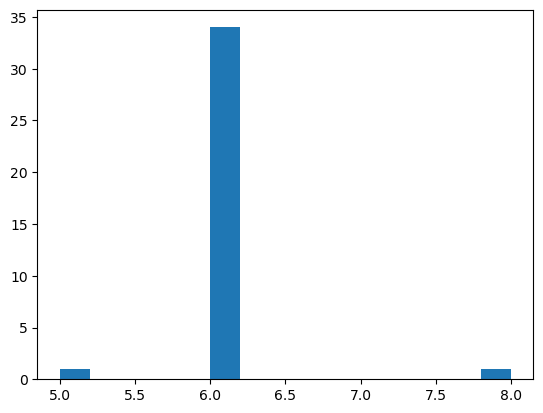

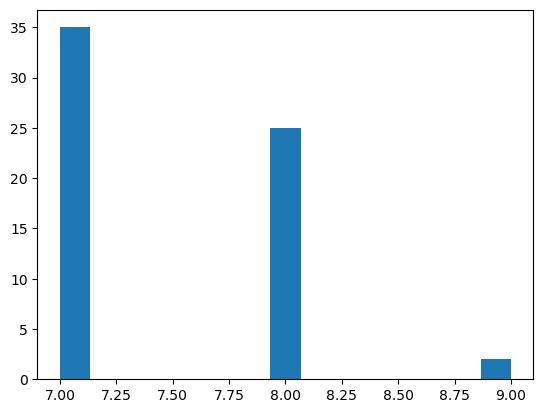

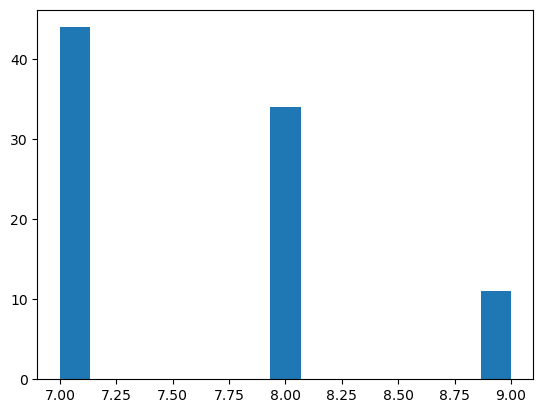

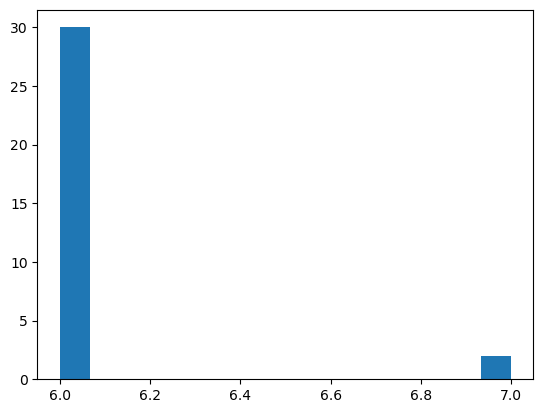

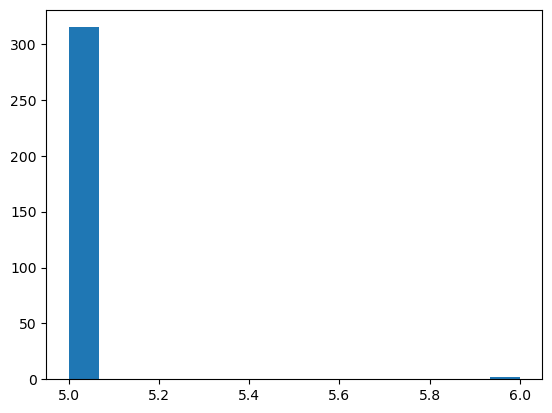

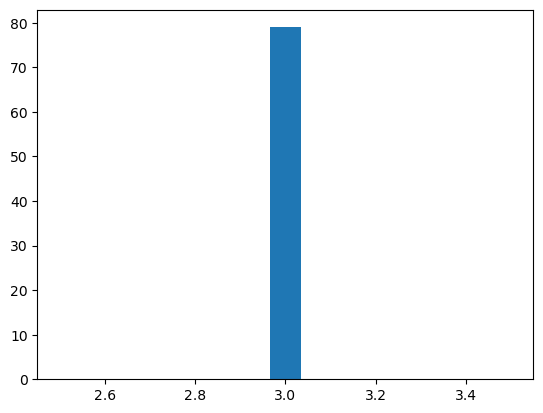

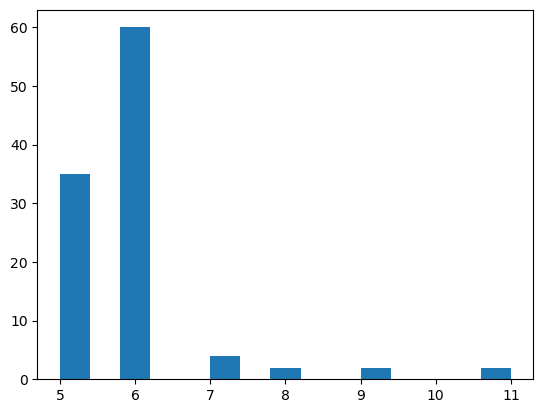

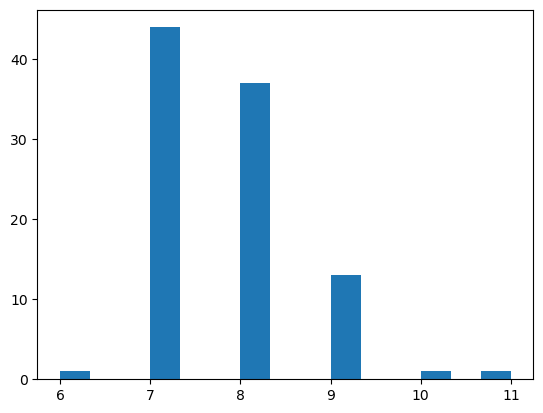

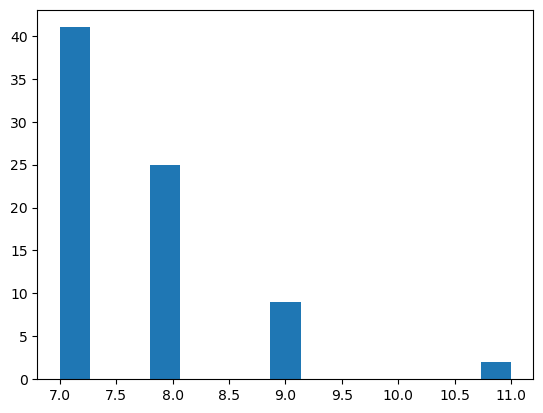

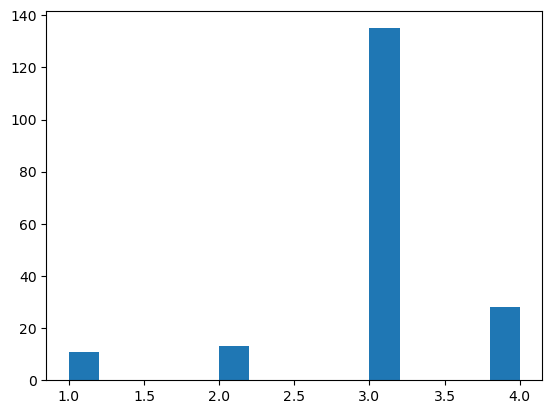

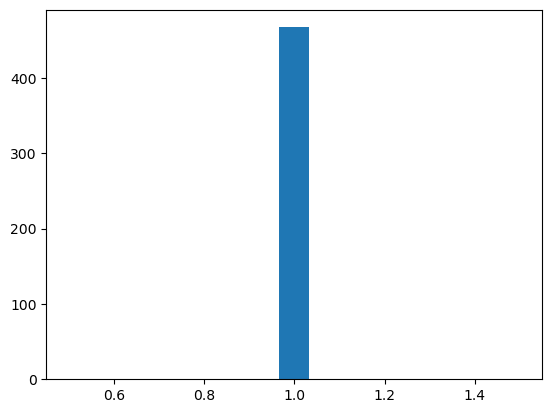

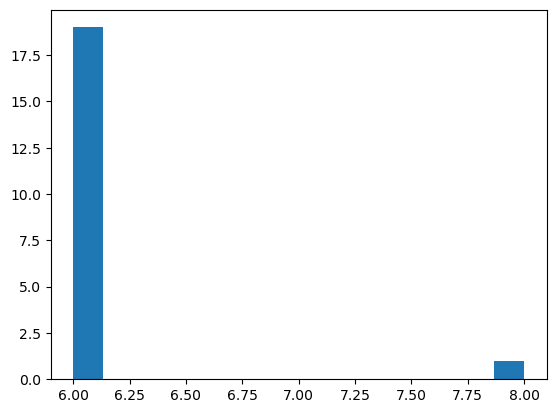

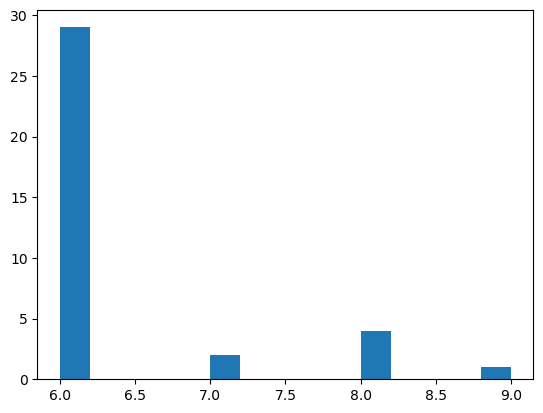

In [127]:
for i in range(1, 21):
    hist_len_p_soins_cluster(patient_custom, i)